
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain AT, MMSL, IB to compute TWL

  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress
from datetime import datetime

import utide # https://github.com/wesleybowman/UTide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL


from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

<xarray.Dataset>
Dimensions:               (time: 636131)
Coordinates:
  * time                  (time) datetime64[ns] 1946-06-07T13:00:00.028800 ... 2018-12-31T22:59:59.971200
Data variables:
    sea_level             (time) float32 ...
    lat                   float32 ...
    lon                   float32 ...
    station_name          |S9 ...
    station_country       |S22 ...
    station_country_code  float32 ...
    uhslc_id              int16 ...
    version               |S1 ...
    gloss_id              float32 ...
    ssc_id                |S4 ...
    decimation_method     int16 ...
    reference_code        |S1 ...
    reference_offset      int16 ...
Attributes:
    title:                  JASL/UHSLC Research Quality Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2020-06-09T10:54:38Z
    publisher_name:         U

Text(0.5, 1.0, 'sea level from UHSLC Tide Gauge')

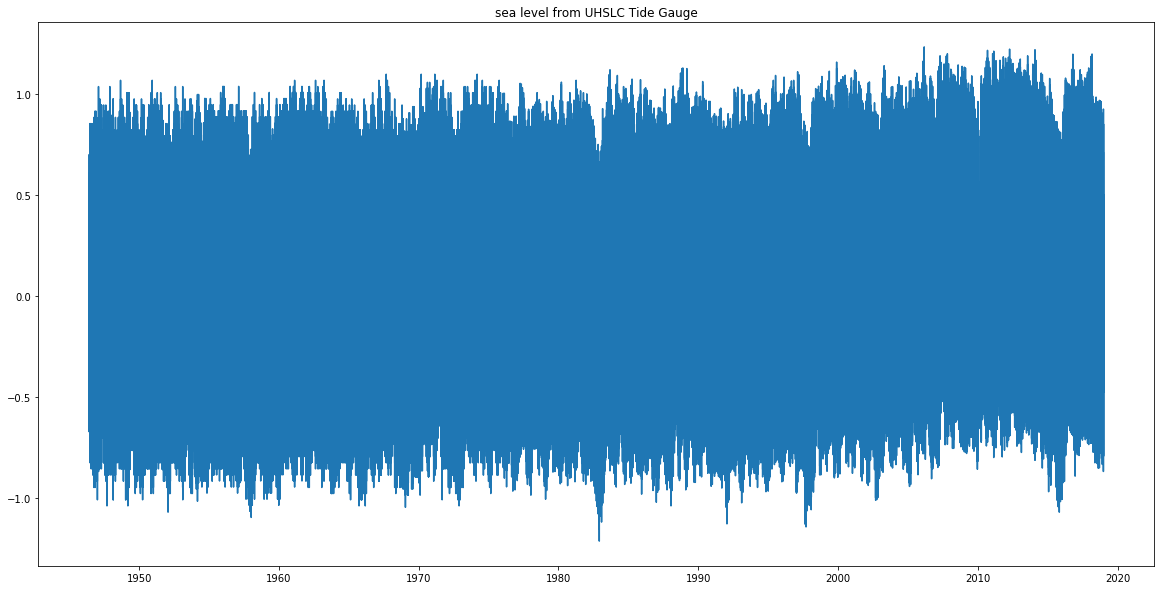

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# Sea Level Pressure for obtain level due to Inverse Barometer (IB)
SLP = db.Load_ESTELA_SLP()   # Sea Level Pressure from CFSR (Pa)


# --------------------------------------
# parameters for mmsl calculation
mmsl_year_ini = 1950
mmsl_year_end = 2018


# --------------------------------------
# Load TG from UHSLC (research quality)
TG, _ = db.Load_TIDE_hist()  
TG = TG.squeeze(dim='record_id')
TG = TG.reset_coords(names='record_id', drop=True)
print(TG)
print()
print(TG.station_name.values)

# to meters and mean sea level = 0
TG['sea_level'] = TG['sea_level']/1000
TG['sea_level'] = TG['sea_level'] - np.nanmean(TG['sea_level'].values)


plt.figure(figsize=(20,10))
plt.plot(TG.time, TG.sea_level)
plt.title('sea level from UHSLC Tide Gauge')


## Obtain Historical level time series:

#### Obtain astronomical tide (AT)

solve: matrix prep ... solution ... diagnostics ... done.
prep/calcs ... done.


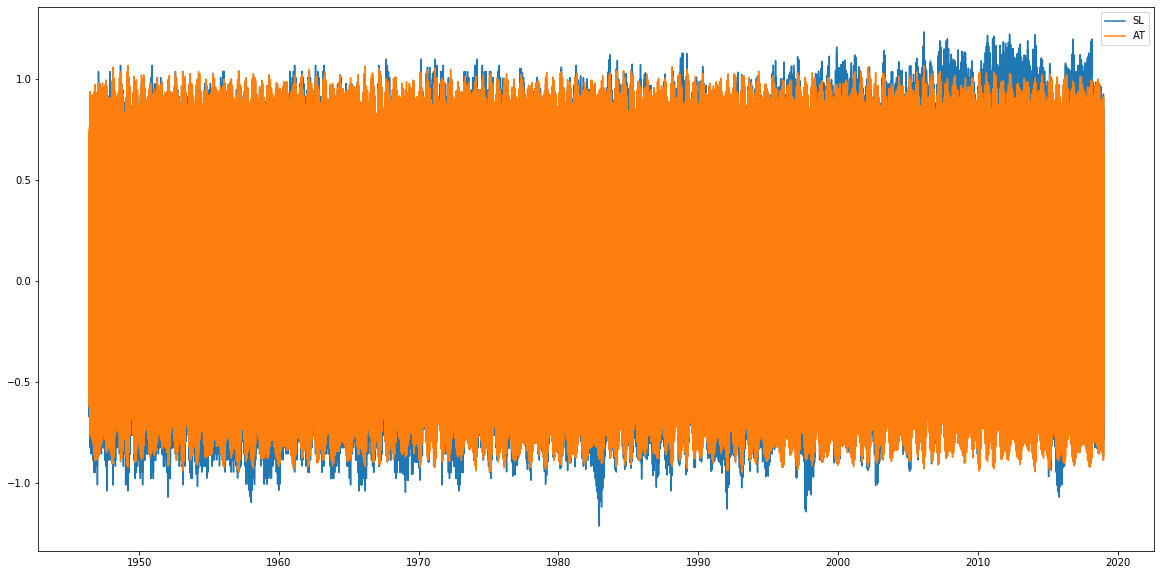

In [5]:
# --------------------------------------
# Obtain AT from TG sea level


# Utide library
#    Parameters
#    ----------
#    t : array_like
#        Time in days since `epoch`.
#    u : array_like
#        Sea-surface height, velocity component, etc.
#    v : {None, array_like}, optional
#        If `u` is a velocity component, `v` is the orthogonal component.
#    lat : float, required
#        Latitude in degrees.
#    epoch : {string, `datetime.date`, `datetime.datetime`}, optional
#        Valid strings are 'python' (default); 'matlab' if `t` is
#        an array of Matlab datenums; or an arbitrary date in the
#        form 'YYYY-MM-DD'.  The default corresponds to the Python
#        standard library `datetime` proleptic Gregorian calendar,
#        starting with 1 at 00:00 on January 1 of year 1; this is
#        the 'datenum' used by Matplotlib.
#    constit : {'auto', array_like}, optional
#        List of strings with standard letter abbreviations of
#        tidal constituents; or 'auto' to let the list be determined
#        based on the time span.
#    conf_int : {'linear', 'MC', 'none'}, optional
#        If not 'none' (string), calculate linearized confidence
#        intervals, or use a Monte-Carlo simulation.
#    method : {'ols', 'robust'}, optional
#        Solve with ordinary least squares, or with a robust algorithm.
#    trend : bool, optional
#        True (default) to include a linear trend in the model.
#    phase : {'Greenwich', 'linear_time', 'raw'}, optional
#        Give Greenwich-referenced phase lags, an approximation
#        using linearized times, or raw lags.
#    nodal : {True, False, 'linear_time'}, optional
#        True (default) to include nodal/satellite corrections;
#        'linear_time' to use the linearized time approximation;
#        False to omit nodal corrections.
        
        
coef = utide.solve(
    matplotlib.dates.date2num(TG.time.values), TG.sea_level.values,
    lat=TG.lat.values,
    nodal=True,
    trend=False,
    method='ols',
    conf_int='MC',
)

tide_tt = utide.reconstruct(matplotlib.dates.date2num(TG.time.values), coef).h


# Plot 
plt.figure(figsize=(20,10))
plt.plot(TG.time, TG.sea_level, label = 'SL')
plt.plot(TG.time, tide_tt, label = 'AT')
plt.legend()



In [6]:
# save

TG_AT = TG.sea_level.copy(deep=True)
TG_AT = TG_AT.to_dataset()
TG_AT['AT']= (('time'),tide_tt)
TG_AT = TG_AT.reset_coords(names='AT')

TG_AT.to_netcdf(op.join(p_data, 'sites', 'KWAJALEIN','TIDE','TG_Kwajalein.nc'))
print(TG_AT)


<xarray.Dataset>
Dimensions:    (time: 636131)
Coordinates:
  * time       (time) datetime64[ns] 1946-06-07T13:00:00.028800 ... 2018-12-31T22:59:59.971200
Data variables:
    sea_level  (time) float32 0.1511321 0.060132146 ... -0.03886795 0.1281321
    AT         (time) float64 0.1782 0.09148 -0.01022 ... -0.2364 -0.05051 0.143


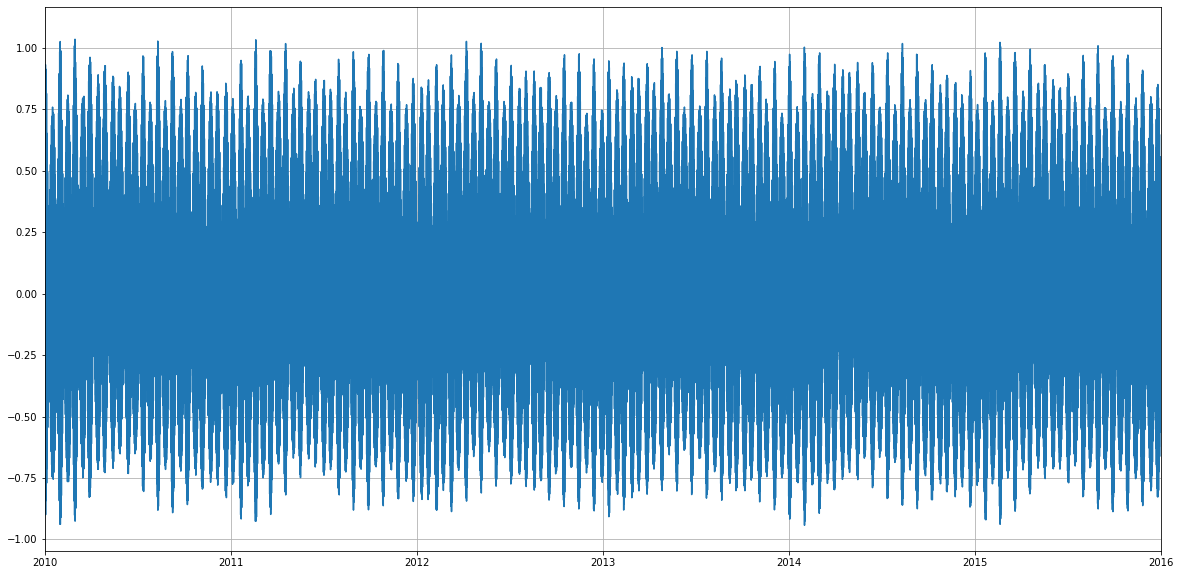

In [6]:
# plot High Tide Flooding Event – Jan 31-Feb 1, 2014 (ppt)

plt.figure(figsize=(20,10))
plt.plot(TG_AT.time, TG_AT.AT)
plt.xlim(datetime(2010,1,1),datetime(2016,1,1))
#plt.xlim(datetime(2014,1,20),datetime(2014,2,10))
plt.grid()


#### Obtain Monthly Mean Sea Level (MMSL)

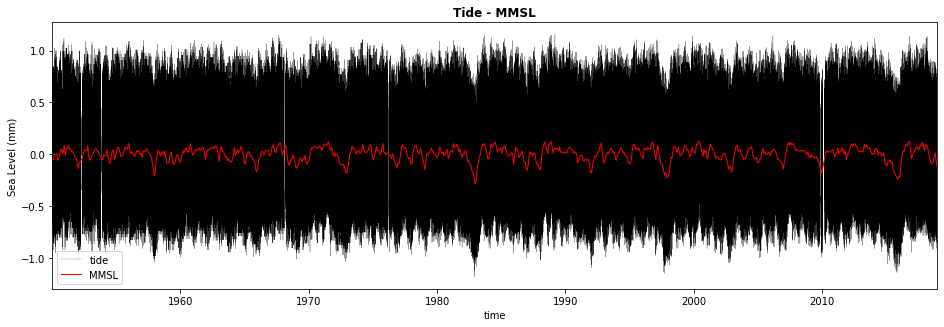

<xarray.Dataset>
Dimensions:      (time: 820)
Coordinates:
  * time         (time) datetime64[ns] 1950-01-16T10:59:59.971200 ... 2018-12-16T10:59:59.971200
Data variables:
    mmsl         (time) float64 -0.04985 -0.0534 0.001096 ... -0.06441 -0.1258
    mmsl_median  (time) float64 -0.07112 -0.07082 -0.009761 ... -0.07653 -0.1225
Attributes:
    source:   teslakit_v0.9.1


In [24]:
# --------------------------------------
# Monthly Mean Sea Level (MMSL)

SL = TG.sea_level.copy(deep=True)
#SL = SL.dropna(dim='time')
#SL = SL.resample(time='1H').interpolate("linear")

# ---------------
# obtain SLR
lr_time = np.array(range(len(SL.time)))  # for linregress
ind_nan = np.where(~np.isnan(SL.values)) # ind no NaNs
slope, intercept, r_value, p_value, std_err = linregress(lr_time[ind_nan], SL.values[ind_nan])
slr = intercept + slope * lr_time

# Plot tide with SLR
#Plot_Tide_SLR(SL.time, SL, slr);

# remove SLR 
SL_noslr = SL - slr


# ---------------
# calculate running mean
time_window = 365*24*3
runm = runmean(SL_noslr, time_window, 'mean')

# Plot SL without SLR and runm
#Plot_Tide_RUNM(SL.time, SL_noslr, runm);

# remove running mean
SL_noslr_norunm = SL_noslr - runm
SLNSR = xr.DataArray(SL_noslr_norunm,  dims=('time'), coords={'time':SL.time.values})


# ---------------
# calculate MMSL
MMSL = Calculate_MMSL(SLNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(SLNSR.time, SLNSR.values, mmsl_time, mmsl_vals);

# store historical mmsl
db.Save_TIDE_hist_mmsl(MMSL)
print(MMSL)



In [4]:
# --------------------------------------
# Inverse Barometer (IB)

SLP_p = SLP.sel(longitude = 168, latitude = 8) # pnt_lon = 167.73, pnt_lat = 8.66


IB = xr.Dataset({'SLP': (('time',), ((SLP_p.SLP - np.mean(SLP_p.SLP.values)) * 0.01))}, # (mb)
                         coords = {'time': SLP_p.time.values})

IB['level'] = (('time'), -1*IB.SLP) # (cm)
IB['level'] = IB['level']/100.0 # (m)
print(IB)


<xarray.Dataset>
Dimensions:  (time: 359401)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-01T01:00:00 ... 2020-01-01
Data variables:
    SLP      (time) float64 -3.029 -3.042 -3.243 -3.66 ... 3.156 3.07 2.555
    level    (time) float64 3.029 3.042 3.243 3.66 ... -3.156 -3.07 -2.555


In [32]:
# --------------------------------------
# Compute Total Water Level (TWL)

# from monthly to hourly
MMSL = MMSL.mmsl.resample(time='1H').interpolate("linear")


# hourly values
TG_AT['time'] = TG_AT['time'].dt.round('H')
MMSL['time'] = MMSL['time'].dt.round('H')
IB['time'] = IB['time'].dt.round('H')

# remove duplicates
_, ix = np.unique(TG_AT['time'], return_index=True); TG_AT = TG_AT.isel(time=ix)
_, ix = np.unique(MMSL['time'], return_index=True); MMSL = MMSL.isel(time=ix)
_, ix = np.unique(IB['time'], return_index=True); IB = IB.isel(time=ix)


# get TWL
TWL = TG_AT.AT + MMSL + IB.level


# save
TWL = TWL.to_dataset(name='TWL')
TWL.to_netcdf(op.join(p_data, 'sites/KWAJALEIN/TIDE/hist_TWL.nc'))
print(TWL)



<xarray.DataArray (time: 350267)>
array([-0.88733266, -0.73687968, -0.42024632, ..., -0.10278752,
       -0.01361527,  0.05257141])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
<xarray.Dataset>
Dimensions:  (time: 350267)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T10:00:00
Data variables:
    TWL      (time) float64 -0.8873 -0.7369 -0.4202 ... -0.1028 -0.01362 0.05257


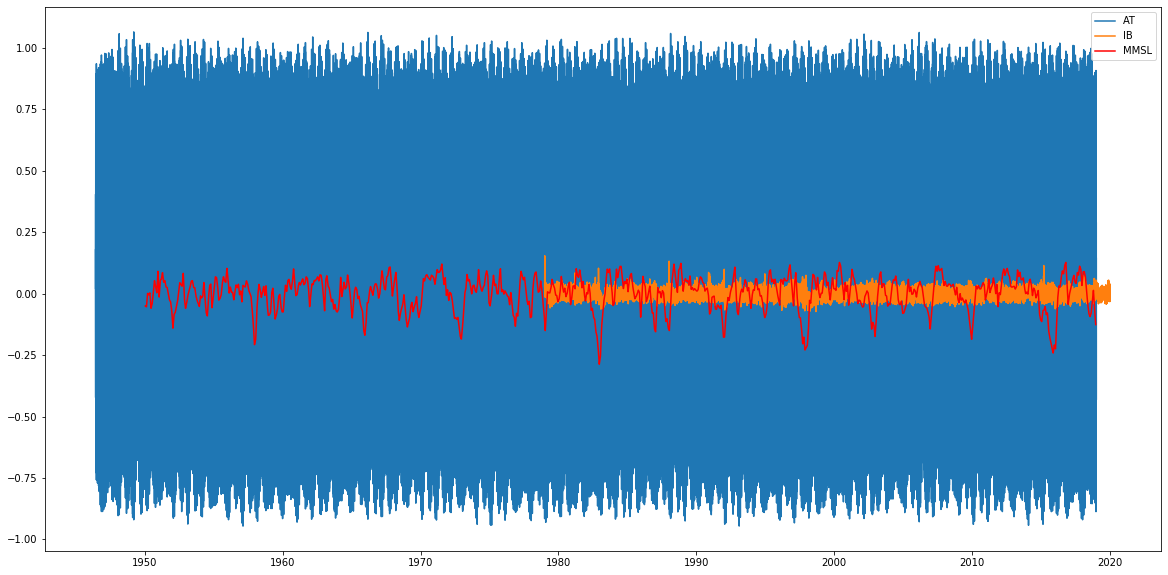

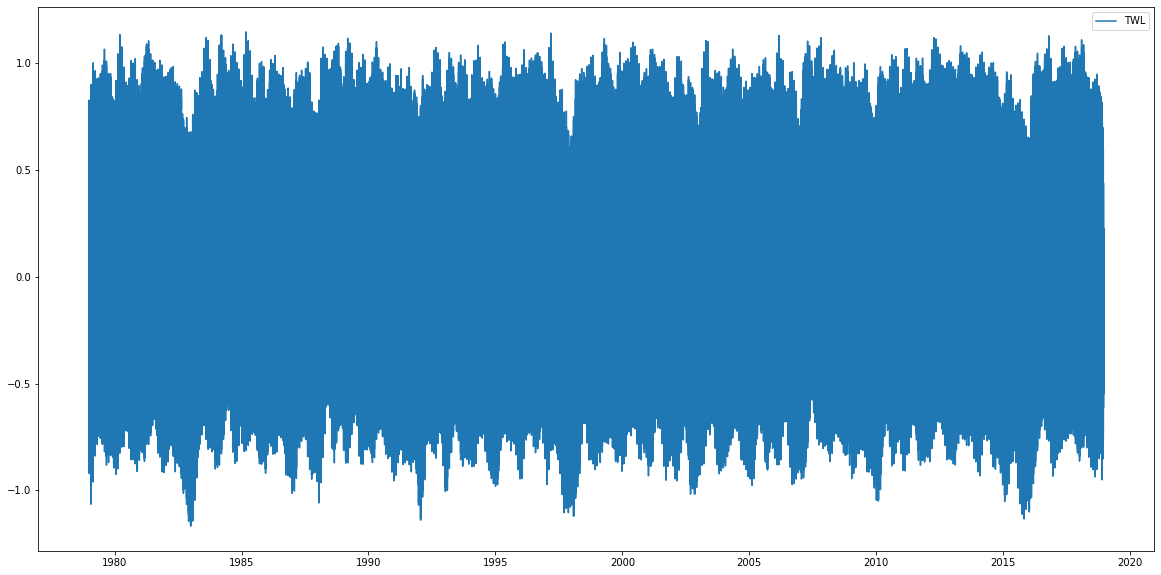

In [38]:

# plot
plt.figure(figsize=(20,10))
plt.plot(TG_AT.time, TG_AT.AT, label='AT')
plt.plot(IB.time, IB.level, label='IB')
plt.plot(MMSL.time, MMSL, color = 'r', label='MMSL')
plt.legend()
#plt.xlim(datetime(1996,1,1), datetime(2014,1,1))

plt.figure(figsize=(20,10))
plt.plot(TWL.time, TWL.TWL, label = 'TWL')
plt.legend()
#plt.xlim(datetime(1996,1,1), datetime(2014,1,1))